# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [1]:
%run -i 'cosim_import.py'

0.post4548.dev0+gc2088dc
2.9.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [2]:
caseH = 18
ict = False
ecc = False
agc = False

%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=434.54 MWh
Online 14477, Q=362.27 MWh, SoC=0.7435
Power(MW): Pt=-39.0266, Pc=-39.0266, Pd=0.0
Ctrl: 0=7897; 1=6580; 
EVA: Load A from Aest.csv.


Generating code for 1 models on 6 processes.


## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


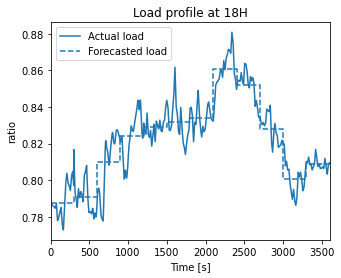

In [3]:
%run -i 'cosim_loadsyn.py'

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [4]:
%run -i 'cosim_setup_dispatch.py'
dc_comp.round(4)

Restricted license - for non-production use only - expires 2023-10-25


RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4889.131


pp cost=2184.5741560778915, gb cost=4889.131241556355


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,970.0313,39.9756,15.8831,1.0,970.0312
1,646.0000,228.9208,2.2281,1.0,646.0000
2,290.0000,81.0987,-0.8653,1.0,290.0000
3,652.0000,114.2245,7.2985,1.0,652.0000
4,508.0000,137.9576,5.4672,1.0,508.0000
5,646.6875,212.0871,6.4196,1.0,646.6875
6,232.0000,55.2884,3.4379,1.0,232.0000
7,564.0000,-59.8950,13.9534,1.0,564.0000
8,865.0000,99.7532,18.9462,1.0,865.0000
9,30.0000,0.0000,18.9462,1.0,30.0000


## Prepare

### Make link table

In [5]:
%run -i 'cosim_linktable.py'
ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,rexc_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,False,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,False,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,False,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,False,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [6]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 0.0, 0.0, 0.05

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Check convergence

In [7]:
# %run -i 'cosim_bmain.py'

Loop

In [ ]:
%run -i 'cosim_main.py'

  0%|                                                          | 0/3600 [00:00<?, ?it/s]RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4660.003
  8%|████                                            | 300/3600 [00:58<11:51,  4.64it/s]RTED GB model is loaded.
RTED is solved.
RTED: total cost=4661.806
 17%|████████                                        | 600/3600 [02:21<15:35,  3.21it/s]RTED GB model is loaded.
RTED is solved.
RTED: total cost=4684.579
 25%|████████████                                    | 900/3600 [04:19<20:23,  2.21it/s]RTED GB model is loaded.
RTED is solved.
RTED: total cost=4701.647
 33%|███████████████▋                               | 1200/3600 [06:55<23:11,  1.72it/s]RTED GB model is loaded.
RTED is solved.
RTED: total cost=4707.302
 42%|███████████████████▌                           | 1500/3600 [10:22<25:54,  1.35it/s]RTED GB model is loaded.
RTED is solved.
RTED: total cost=4710.702
 46%|█████████████████████▋          

In [ ]:
ssa.exit_code

In [ ]:
sse.plot_agc(style='ieee')

In [ ]:
%run -i 'cosim_plot.py'

In [ ]:
# --- save output ---
file_beging = 'cosim_'
sim_name = 'ieee39_s'

cosim_out.to_csv(file_beging + sim_name + '_out.csv', index=False)
sse_out.to_csv(file_beging + sim_name + '_sse.csv', index=False)
bu_df.to_csv(file_beging + sim_name + '_bu.csv', index=False)
bd_df.to_csv(file_beging + sim_name + '_bd.csv', index=False)
pg_df.to_csv(file_beging + sim_name + '_pg.csv', index=False)
agc_mile.to_csv(file_beging + sim_name + '_agcm.csv', index=False)
sfr_res.to_csv(file_beging + sim_name + '_sfr.csv', index=False)
ev_agc.to_csv(file_beging + sim_name + '_evagc.csv', index=False)
ev_soc.iloc[0:800].to_csv(file_beging + sim_name + '_evsoc1.csv', index=False)
ev_soc.iloc[800:].to_csv(file_beging + sim_name + '_evsoc2.csv', index=False)
sse.ev.to_csv(file_beging + sim_name + '_evdata.csv', index=False)

import csv
new_path = open(file_beging + sim_name + '_rted.csv', 'w')
z = csv.writer(new_path)
for new_k, new_v in rted_res.items():
    z.writerow([new_k, new_v])
new_path.close()